# **KNN 알고리즘을 활용하여 모의고사 데이터를 분석해보자!**

## 0. 데이터셋 만들기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns

X, y = make_blobs(n_samples=200, centers=[[92, 87], [90, 90]], center_box=(80, 100))

y = np.where(y == 0, '철수', '영희')

sns.scatterplot(x = X[:,0], y = X[:,1], hue=y)

df = pd.DataFrame({
    '국어': X[:, 0],
    '수학': X[:, 1],
    '이름': y
})


df[:160].to_csv('mogo_train.csv', index = False)
df[160:].to_csv('mogo_test.csv', index = False)

## 1. 프로젝트 목적 및 정의

수능 D-365를 맞은 고등학생 철수와 영희는 수능을 보기 전 모의고사를 보고자 했습니다.  
200개 정도의 모의고사를 풀어본 철수와 영희는 어느 순간부터 이름을 쓰는걸 까먹고 말았습니다.   
오답노트를 작성하기 위해 각자 시험지를 찾았지만, 이름이 쓰여 있지 않아 찾을 수 없었습니다.   
철수와 영희는 각각 국어와 수학을 좀 더 잘한다는 걸 알고 있지만, 그것만으로는 모의고사 시험지의 주인을 알기 어렵습니다.    
철수와 영희는 이름이 쓰여 있는 160개 정도의 모의고사 시험지를 활용하여 나머지 40개 모의고사 시험지의 주인을 찾고자 합니다.  
여러분이 철수와 영희를 도와 시험지의 주인을 찾아주세요.  

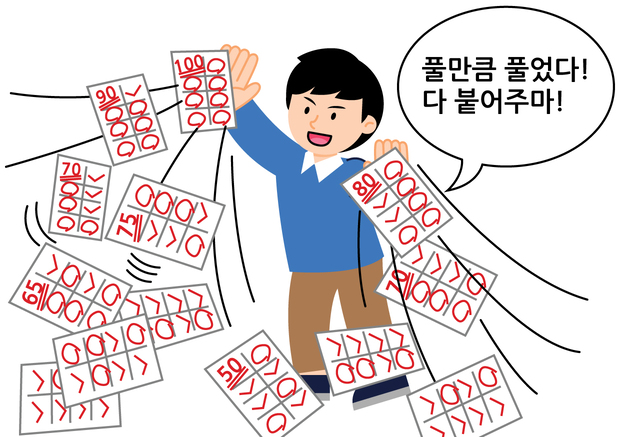


## 2. 데이터셋 불러오기

### 예제 1.
먼저 이름과 성적 정보가 저장되어 있는 훈련용 데이터셋을 불러와주세요.
* pd.read_csv를 사용하면 파일을 데이터로 불러올 수 있습니다.
* 데이터의 앞부분 5개를 살펴봅시다. df.head 함수를 사용하면 데이터의 앞부분이 5줄이 반환됩니다.  

In [ ]:
import pandas as pd

df = pd.read_csv('mogo_train.csv')
df.head()

## 3. 데이터 전처리 및 시각화

### 예제 2.
여러분은 데이터의 이름이 철수와 영희로 구성되어있는 것을 확인했습니다.   모델을 훈련시키기 위해서는 주어진 이름을 숫자 0, 1로 바꿀 필요가 있습니다.  
불러온 dataframe에 label이라는 새로운 column을 만들고 철수인 경우 0, 영희인 경우 1을 부여해주세요.
* `df.loc[<조건>, <column 이름>] = value`: 데이터프레임에서 특정 조건을 만족하는 열의 column에 값을 지정해줍니다.
* `df[<column 이름>] == value`: 데이터프레임에서 column에 해당하는 값이 value인지를 판정합니다. 위에서 조건으로 사용될 수 있습니다.

In [ ]:
df.loc[df['이름'] == '철수', 'label'] = 0 # '이름'열에 해당하는 값이 '철수'인지를 확인하여, 조건에 부합하면 'label'열 값을 0으로 지정합니다.
df.loc[df['이름'] == '영희', 'label'] = 1

df.head()

### 예제 3.
주어진 데이터의 분포를 대략적으로 알아보기 위해서 시각화를 해보겠습니다.  
국어 점수를 x축, 수학 점수를 y축으로 하는 산점도를 그려봅시다. 철수와 영희가 본 모의고사를 구분할 수 있게 각 점에 색을 입혀주세요.    
* 산점도는 아래 함수를 이용하면 그릴 수 있어요.
  ```python
    sns.scatterplot(
       data=df,
       x=<x축에 올 column 이름>,
       y=<y축에 올 column 이름>,
       hue=<각 점을 구분할 기준의 column 이름>
    )
  ```

In [ ]:
import seaborn as sns

sns.scatterplot(data=df, x='국어', y='수학', hue='이름')

### 예제 4. 
국어 점수와 수학 점수가 90점 부근에 위치한다는 것을 확인했습니다.  
모델의 성능을 더 올려주기 위해서는 데이터를 정규화 시켜줘야 합니다.  
아래와 같이 정규화 시켜주세요.

$$
\text{표준화된 국어 점수} = \frac{\text{국어 점수} - \text{국어 점수의 평균}}{\text{국어 점수의 표준편차}}
\\
\text{표준화된 수학 점수} = \frac{\text{수학 점수} - \text{수학 점수의 평균}}{\text{수학 점수의 표준편차}}
$$

* `df.mean()`: 데이터프레임의 각 column의 평균을 반환합니다.
* `df.std()`: 데이터프레임의 각 column의 표준편차를 반환합니다.

In [ ]:
X = df[['국어', '수학']]
X_train = (X - X.mean()) / X.std()

X_train.head()

### 예제 5.  
훈련에 쓰이기 위한 라벨을 따로 저장해봅시다.

In [ ]:
y_train = df['label']

y_train.head()

## 4. 모델 학습

이번 예제에서는 KNN 알고리즘을 사용합니다. 실제 구현에 앞서 KNN 알고리즘의 작동원리를 배워봅시다.  

### KNN 알고리즘
먼저 아래와 같이 2차원 데이터, 3개의 클래스가 다음과 같이 군집처럼 분포되어있다고 가정하자.  
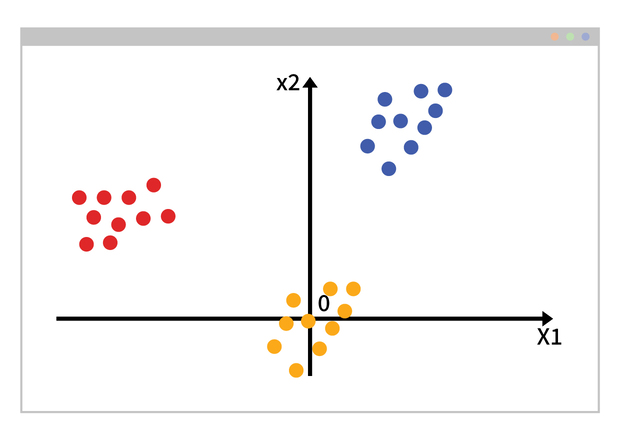    

만약 여기에 아래 그림의 노란색 점이 주어지고, 그것의 클래스를 추측한다면 아마 주황색이라고 예측할 것입니다. 주황색의 군집과 가장 가깝기 때문입니다. 이처럼 KNN 알고리즘은 새로운 점이 주어졌을 때 주위 K개의 점이 어느 라벨에 속하는지를 사용해 학습합니다.  
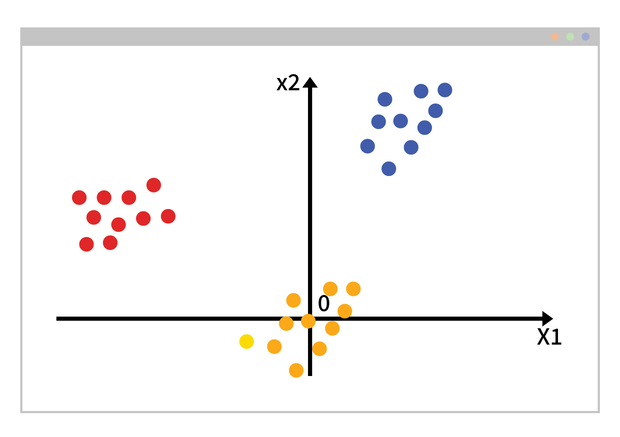


### 예제 6.
KNN을 알고리즘으로 사용하는 모델에 주어진 데이터를 학습시켜보자.
* `model = KNeighborsClassifier(n_neighbors=k)`: KNN 모델을 반환합니다. k개의 이웃한 점을 기준으로 판단합니다.
* `model.fit(X, y)`: 주어진 데이터 X, y를 사용해 모델을 훈련시킵니다. X는 입력값, y는 그에 상응하는 라벨 혹은 클래스를 의미합니다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


## 5. 모델 예측 및 평가

### 예제 7.
`mogo_test.csv`는 테스트용 데이터를 의미합니다. 앞서 train 데이터를 전처리한 것 처럼 test 데이터도 전처리해주세요.
* 앞에서 사용한 코드를 사용합니다.
* 단, 정규화를 할때는 train data의 평균과 분산을 사용합니다.


In [ ]:
import pandas as pd

df_test = pd.read_csv('mogo_test.csv')

df_test.loc[df_test['이름'] == '철수', 'label'] = 0  # label을 만들어줍니다. 
df_test.loc[df_test['이름'] == '영희', 'label'] = 1

X_test = df_test[['국어', '수학']]  # 국어, 수학 열만 따로 저장하여 정규화 시켜줍니다. 
X_test = (X_test - X.mean()) / X.std()
y_test = df_test['label']

print(X_test.head())
print(y_test.head())

### 정확도

우리는 모델이 예측한 정답을 정확도(accuracy)라는 지표를 사용해 평가할거에요. 정답이 예측한 값과 얼마나 동일한지를 나타낼 수 있는 지표에요.   
정확도는 다음과 같이 측정해요.  
$$
\frac{\text{맞은 개수}}{\text{맞은 개수} + \text{틀린 개수}}
$$
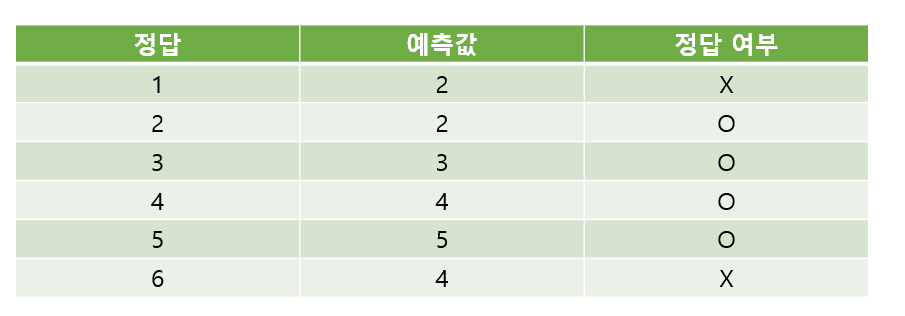  
위의 경우, 답인 경우가 4가지, 틀린 경우가 2가지이므로 정확도는 $\frac{4}{2 + 4} = 0.666...$이에요.

### 예제 8.
전처리한 test 데이터에 대해서 모델의 성능을 평가해주세요. 모델의 성능은 정확도로 평가합니다.

* `model.score(X, y)`: X와 y에 대해서 model의 예측 성능을 정확도로 평가합니다.

In [ ]:
model.score(X_test, y_test)

### 예제 9.
test 데이터를 어떻게 예측했는지 예제 3.과 같이 산점도를 그려주세요. 단, 이번에는 라벨을 실제값으로 설정해주세요.
* 예측값이 실제값과 동일한지 살펴보아요.

In [ ]:
sns.scatterplot(data = df_test, x = '국어', y = '수학', hue=y_test)

## 6. 결론

철수와 영희는 주어진 많은 모의고사들을 한번에 구분할 수 있었습니다.  
철수와 영희는 성공적으로 모의고사의 오답노트를 작성할 수 있었답니다 ^~^  
